# Benchmarking: predicting retinotopic organization from brain structure

Here we benchmark our approach by comparing our current model performance against two other approches that predict retinotopic organization from brain structure solely. These approaches are deepRetinotopy 1.0 (Ribeiro, Bollmann, Puckett, 2021) and Benson14 (Benson et al., 2014).
We use two metrics for benchmarking: error and individual variability. Error is given by the smallest difference between two angles and is determined as the difference between the predicted and the empirical angle values in a vertex-wise manner and averaged across a given region of interest. Our second metric, individual variability, was determined by the difference between a specific predicted map and each other predicted map in the test set in a vertex-wise manner and averaged across all combinations (there are 10 participants in the test set, hence 9 combinations), and then averaged within the various ROIs.


## Import libraries and functions

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
import astropy.units as u
import numpy as np
import nibabel as nib
import os.path as osp

sys.path.append('./../')

from functions.evaluation import *
from astropy.stats import circcorrcoef

## Benchmarking

First, we need to run neuropythy on the HCP dataset to estimate retinotopic maps from brain structure using benson14_retinotopy model. To do it, we need to first set up the ~/.npythyrc configuration file (see [documentation](https://github.com/noahbenson/neuropythy)) with appropriate paths:

```
{"freesurfer_subject_paths": "/PATH_TO_FREESURFER_DATA",
 "data_cache_root":          "~/tmp/npythy_cache",
 "hcp_subject_paths":        "",
 "hcp_auto_download":        true,
 "hcp_credentials":          ""}
```

Additionally, make sure each subject folder contain all freesurfer dirs, i.e., 

```
.
├── label
├── mri
├── scripts
├── stats
├── surf
└── touch
```

Then we can run the following bash scrip that will perform all the required steps.

In [ ]:
%%bash
ml connectomeworkbench/1.5.0
ml freesurfer/7.3.2

cd ../HCP/freesurfer
for sub in *; do
    cd $sub
    # 1. Download required nifti files
    aws s3 cp s3://hcp-openaccess/HCP_1200/$sub/T1w/$sub/mri/brain.mgz ./mri/brain.mgz 
    aws s3 cp s3://hcp-openaccess/HCP_1200/$sub/T1w/$sub/mri/ribbon.mgz ./mri/ribbon.mgz 
    # 2. Estimate retinotopic maps with benson14 model
    python -m neuropythy benson14_retinotopy $sub --no-volume-export -v --surf-format=mgz
    # 3. Convert retinotopic maps to gifti
    for hemisphere in lh rh; do
        for metric in angle eccen sigma varea; do
            mris_convert -c ./surf/"$hemisphere".benson14_"$metric".mgz ./surf/"$hemisphere".white \
                        ./surf/"$hemisphere".benson14_"$metric".gii
        done
    done
    # 4. Convert polar angle maps
    for hemisphere in lh rh; do
        # Convert to 0-360 range
        python -c "import sys; sys.path.append('/home/ribeiro/Projects/deepRetinotopy_validation/'); from functions.preprocess import transform_polarangle_neuropythy; transform_polarangle_neuropythy('./surf/"$hemisphere".benson14_angle.gii', '"$hemisphere"')"
    done                  
    cd ..
done

# 5. Register data from native space to 32k_fs_LR space
for sub in *; do
    for hemisphere in lh rh; do
        if [ $hemisphere == "lh" ]; then
            hemi="L"
        else
            hemi="R"
        fi
        for metric in angle eccen sigma; do
            if [ $metric == "angle" ]; then
                metric_new="polarAngle"
            elif [ $metric == "eccen" ]; then
                metric_new="eccentricity"
            elif [ $metric == "sigma" ]; then
                metric_new="pRFsize"
            fi
            if [ $metric == "angle" ] && [ $hemisphere == "lh" ]; then
                python -c "import sys; sys.path.append('/home/ribeiro/Projects/deepRetinotopy_validation/'); \
                                    from functions.preprocess import transform_angle_lh_nsd; \
                                    transform_angle_lh_nsd('"$sub"/surf/lh.benson14_angle_transformed.gii')"

                wb_command -metric-resample "$sub"/surf/"$hemisphere".benson14_angle_transformed_transformed.gii \
                "$sub"/surf/"$hemisphere".sphere.reg.surf.gii /home/ribeiro/Projects/deepRetinotopy_validation/templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                ADAP_BARY_AREA $sub/surf/"$hemisphere".benson14_"$metric_new".func.gii \
                -area-surfs $sub/surf/"$hemisphere".midthickness.surf.gii $sub/surf/"$sub"."$hemisphere".midthickness.32k_fs_LR.surf.gii         
            else
                wb_command -metric-resample "$sub"/surf/"$hemisphere".benson14_"$metric".gii \
                "$sub"/surf/"$hemisphere".sphere.reg.surf.gii /home/ribeiro/Projects/deepRetinotopy_validation/templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                ADAP_BARY_AREA $sub/surf/"$hemisphere".benson14_"$metric_new".func.gii \
                -area-surfs $sub/surf/"$hemisphere".midthickness.surf.gii $sub/surf/"$sub"."$hemisphere".midthickness.32k_fs_LR.surf.gii         
            fi
        done
    done
done

### Models' performance across visual areas

Here we have the code for generating the plots shown in Figure 2.

In [12]:
# Function for benchmarking models across early visual areas

from deepRetinotopy_TheToolbox.utils.rois import ROIs_WangParcels as roi_parcel

def benchmark_models(path, retinotopic_map, hemisphere, 
                     retinotopic_mapping = 'continuous', threshold = 10, 
                     list_of_models = ['deepRetinotopy25', 'deepRetinotopy21','benson14'], 
                     region_of_interest = 'earlyVisualCortex'):
    """Calculate the inter-individual variability in predicted maps and the error
    between predicted and empirical maps for different models.
    
    Args:
        path (str): Path to the Freesurfer directory 
        retinotopic_map (str): Type of retinotopic map ('polarAngle', 'eccentricity' or 'pRFsize')
        hemisphere (str): Hemisphere ('lh' or 'rh')
        retinotopic_mapping (str): Type of retinotopic mapping ('continuous' or 'discrete')
        threshold (float): Threshold for the explained variance
        list_of_models (list): List of models to benchmark. 
            Default is ['deepRetinotopy25', 'deepRetinotopy21','benson14'].
        region_of_interest (str): Region of interest to benchmark.
            Default is 'earlyVisualCortex'.

    Returns:
        df (pandas dataframe): Dataframe containing the inter-individual variability in predicted maps 
            and the error.
        plt (matplotlib.pyplot): Plot of the inter-individual variability in predicted maps and the error. 
            PNG file saved at the output folder.
    """
    # Variables
    mean_ind_variability = []
    error = []
    # Test dataset from HCP
    test_set = ['680957', '191841', '617748', '725751', '198653',
                         '191336', '572045', '601127', '644246', '157336']
    # Number of nodes
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)

    # Region of interest 
    ## Region of interest used for training
    final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
    ROI_masked = np.zeros((32492, 1))
    ## Early visual cortex
    print('Region of interest: ' + region_of_interest)
    if region_of_interest == 'earlyVisualCortex':
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])
    elif region_of_interest != 'earlyvisualcortex':
        if region_of_interest == 'V1':
            areas = ['V1v', 'V1d']
        elif region_of_interest == 'V2':
            areas = ['V2v', 'V2d']
        elif region_of_interest == 'V3':
            areas = ['V3v', 'V3d']
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_parcel(areas)
    visualarea = np.zeros((32492, 1))
    ## Hemisphere
    if hemisphere == 'lh':
        ROI_masked[final_mask_L_ROI == 1] = 1
        visualarea[final_mask_L == 1] = 1
    else: 
        ROI_masked[final_mask_R_ROI == 1] = 1
        visualarea[final_mask_R == 1] = 1
    ## Final mask (selecting V1-V3 vertices)
    mask = ROI_masked + visualarea
    mask = mask[ROI_masked == 1]
    mask = mask > 1

    for model in list_of_models:
        theta_withinsubj = []
        theta_acrosssubj_pred = []
        for j in range(len(test_set)):
            theta_pred_across_temp = []
            for i in range(len(test_set)):
                # Error
                if i == j:
                    # Loading maps
                    if model == 'benson14':
                        predicted_map = np.array(nib.load(osp.join(path, test_set[i] + '/surf/' + hemisphere + '.benson14_' + retinotopic_map + '.gii')).agg_data()).reshape(
                                        number_hemi_nodes, -1)[ROI_masked == 1]
                    elif model == 'deepRetinotopy25':    
                        predicted_map = np.array(nib.load(osp.join(path, test_set[i] + '/deepRetinotopy/' + test_set[i] + '.fs_predicted_' + 
                                        retinotopic_map + '_' + hemisphere + '_curvatureFeat_model.func.gii')).agg_data()).reshape(
                                        number_hemi_nodes, -1)[ROI_masked == 1]
                    elif model == 'deepRetinotopy21': 
                        predicted_map = np.array(nib.load(osp.join(path,  '../predicted_deepRetinotopy_21/' + test_set[i] + '.fs_predicted_' + 
                                        retinotopic_map + '_' + hemisphere + '_curvatureMyelinFeat_model.func.gii')).agg_data()).reshape(
                                        number_hemi_nodes, -1)[ROI_masked == 1]
                    empirical_map = np.array(nib.load(osp.join(path, test_set[i] + '/deepRetinotopy/' + test_set[i] + '.fs_empirical_' + 
                                     retinotopic_map + '_' + hemisphere + '.func.gii')).agg_data()).reshape(
                                     number_hemi_nodes, -1)[ROI_masked == 1]
                    variance_explained = np.array(nib.load(osp.join(path, test_set[i] + '/deepRetinotopy/' + test_set[i] + '.fs_empirical_variance_explained_' +
                                     hemisphere + '.func.gii')).agg_data()).reshape(
                                        number_hemi_nodes, -1)[ROI_masked == 1][mask]

                    # Transform polar angle values from lh
                    if retinotopic_map == 'polarAngle' and hemisphere == 'lh':
                        predicted_map = transform_polarangle(predicted_map) 
                        empirical_map = transform_polarangle(empirical_map)

                    assert np.min(predicted_map[mask]) >= 0.
                    assert np.min(empirical_map[mask]) >= 0.
                    
                    # Transforming to radians
                    if retinotopic_map == 'polarAngle' or retinotopic_map == 'eccentricity':
                        predicted_map = np.array(predicted_map) * (np.pi / 180)
                        empirical_map = np.array(empirical_map) * (np.pi / 180)
                    elif retinotopic_map == 'pRFsize':
                        predicted_map = np.array(predicted_map)
                        empirical_map = np.array(empirical_map)

                    # Calculating error
                    if retinotopic_mapping == 'continuous':
                        if retinotopic_map == 'polarAngle' or retinotopic_map == 'eccentricity':
                            theta = smallest_angle(predicted_map[mask],
                                            empirical_map[mask])
                            if threshold != None:
                                theta = theta[variance_explained > threshold]
                        elif retinotopic_map == 'pRFsize':
                            theta = np.abs(predicted_map[mask] - empirical_map[mask])
                            if threshold != None:
                                theta = theta[variance_explained > threshold]
                        theta_withinsubj.append(np.mean(theta))

                    elif retinotopic_mapping == 'discrete':
                        if retinotopic_map == 'polarAngle' or retinotopic_map == 'eccentricity':
                            overlap = calculate_overlap(predicted_map, empirical_map, retinotopic_map, mask, angle = 'rad', hemisphere = hemisphere)
                        else:
                            overlap = calculate_overlap(predicted_map, empirical_map, retinotopic_map, mask, angle = 'original', hemisphere = hemisphere)
                        theta_withinsubj.append(overlap)

                # Inter-individual variability in predicted maps
                if i != j:
                    # Loading maps
                    if model == 'benson14':
                        predicted_map_1 = np.array(nib.load(osp.join(path, test_set[i] + '/surf/' + hemisphere + '.benson14_' + retinotopic_map + '.gii')).agg_data()).reshape(
                                        number_hemi_nodes, -1)[ROI_masked == 1]
                        predicted_map_2 = np.array(nib.load(osp.join(path, test_set[j] + '/surf/' + hemisphere + '.benson14_' + retinotopic_map + '.gii')).agg_data()).reshape(
                                        number_hemi_nodes, -1)[ROI_masked == 1]
                    elif model == 'deepRetinotopy25':
                        predicted_map_1 = np.array(nib.load(osp.join(path,
                                            test_set[i] + '/deepRetinotopy/' + test_set[i] + '.fs_predicted_' + 
                                            retinotopic_map + '_' + hemisphere + '_curvatureFeat_model.func.gii')).agg_data()).reshape(
                                            number_hemi_nodes, -1)[ROI_masked == 1]
                        predicted_map_2 = np.array(nib.load(osp.join(path,
                                            test_set[j] + '/deepRetinotopy/' + test_set[j] + '.fs_predicted_' + 
                                            retinotopic_map + '_' + hemisphere + '_curvatureFeat_model.func.gii')).agg_data()).reshape(
                                            number_hemi_nodes, -1)[ROI_masked == 1]
                    elif model == 'deepRetinotopy21':
                        predicted_map_1 = np.array(nib.load(osp.join(path,
                                            '../predicted_deepRetinotopy_21/' + test_set[i] + '.fs_predicted_' +  
                                            retinotopic_map + '_' + hemisphere + '_curvatureMyelinFeat_model.func.gii')).agg_data()).reshape(
                                            number_hemi_nodes, -1)[ROI_masked == 1]
                        predicted_map_2 = np.array(nib.load(osp.join(path,
                                            '../predicted_deepRetinotopy_21/' + test_set[j] + '.fs_predicted_' + 
                                            retinotopic_map + '_' + hemisphere + '_curvatureMyelinFeat_model.func.gii')).agg_data()).reshape(
                                            number_hemi_nodes, -1)[ROI_masked == 1]
                    
                    # Transform polar angle values from lh
                    if retinotopic_map == 'polarAngle' and hemisphere == 'lh':
                        predicted_map_1 = transform_polarangle(predicted_map_1)
                        predicted_map_2 = transform_polarangle(predicted_map_2)
                    
                    assert np.min(predicted_map_1[mask]) >= 0.
                    assert np.min(predicted_map_2[mask]) >= 0.
                    
                    # Transforming to radians
                    if retinotopic_map == 'polarAngle' or retinotopic_map == 'eccentricity':
                        predicted_map_1 = np.array(predicted_map_1) * (np.pi / 180)
                        predicted_map_2 = np.array(predicted_map_2) * (np.pi / 180)
                    elif retinotopic_map == 'pRFsize':
                        predicted_map_1 = np.array(predicted_map_1)
                        predicted_map_2 = np.array(predicted_map_2)
                    
                    # Calculating inter-individual variability
                    if retinotopic_mapping == 'continuous':
                        if retinotopic_map == 'polarAngle' or retinotopic_map == 'eccentricity':
                            theta_pred = smallest_angle(predicted_map_1[mask],
                                                    predicted_map_2[mask])
                        elif retinotopic_map == 'pRFsize':
                            theta_pred = np.abs(predicted_map_1[mask] - predicted_map_2[mask])
                        theta_pred_across_temp.append(np.mean(theta_pred))
                    elif retinotopic_mapping == 'discrete':
                        if retinotopic_map == 'polarAngle' or retinotopic_map == 'eccentricity':
                            overlap = calculate_overlap(predicted_map_1, predicted_map_2, retinotopic_map, mask, angle = 'rad', hemisphere = hemisphere)
                        else:
                            overlap = calculate_overlap(predicted_map_1, predicted_map_2, retinotopic_map, mask, angle = 'original', hemisphere = hemisphere)
                        theta_pred_across_temp.append(overlap)
                        
            theta_acrosssubj_pred.append(theta_pred_across_temp)

        mean_theta_withinsubj = np.array(theta_withinsubj)
        mean_theta_acrosssubj_pred = np.mean(np.array(theta_acrosssubj_pred), axis=1)

        error.append(mean_theta_withinsubj)
        mean_ind_variability.append(mean_theta_acrosssubj_pred)

    error = np.reshape(np.array(error), (len(list_of_models), -1))
    mean_ind_variability = np.reshape(np.array(mean_ind_variability), (len(list_of_models), -1))
    
    # Create dataframe
    data_error = [[error[i], 
                    len(mean_ind_variability[i]) * [list_of_models[i]],
                    len(mean_ind_variability[i]) * ['Error']] for i in range(len(list_of_models))]
    data_ind_variability = [[mean_ind_variability[i], 
                             len(mean_ind_variability[i]) * [list_of_models[i]],
                            len(mean_ind_variability[i]) * ['Individual variability']] for i in range(len(list_of_models))]

    data = np.concatenate(data_error + data_ind_variability, axis = 1)

    df = pd.DataFrame(columns=['$\Delta$$\t\Theta$', 'Model', 'Metric'],
                      data=data.T)
    df['$\Delta$$\t\Theta$'] = df['$\Delta$$\t\Theta$'].astype(float)

    # Generate plot
    if os.path.isdir('../output/benchmarking/') == False:
        os.makedirs('../output/benchmarking/')
        
    sns.set_style("white")
    fig = plt.figure()
    if retinotopic_map == 'polarAngle':
        palette_1 = ['#340f5aff','#7769a3ff','#bfbcd8ff',]
    else:
        palette_1 = ['#bb702bff','#e7a658ff','#f8ddb2ff',]
    ax = sns.barplot(data=df, y='$\Delta$$\t\Theta$', x="Metric", hue='Model',
                    palette=palette_1, )
    sns.despine()
    if retinotopic_map == 'polarAngle':
        map_title = 'Polar Angle'
        plt.ylim(0, 30)
        plt.ylabel('$\Delta$$\t\Theta$ (degrees)')
    elif retinotopic_map == 'eccentricity':
        map_title = 'Eccentricity'
        plt.ylim(0, 3)
        plt.ylabel('$\Delta$$\t\Theta$ (degrees)')
    elif retinotopic_map == 'pRFsize':
        map_title = 'pRF size'
        plt.ylim(0, 3)
        plt.ylabel('$\Delta$$\t\Theta$ (degrees)')

    if hemisphere == 'lh':
        hemisphere_title = '(LH)'
    elif hemisphere == 'rh':
        hemisphere_title = '(RH)'
    
    if region_of_interest == 'earlyVisualCortex':
        region_of_interest_title = 'Early Visual Cortex'
        fig.suptitle(region_of_interest_title + ' - ' + map_title + ' ' + hemisphere_title)   
    else:
        fig.suptitle(region_of_interest + ' - ' + map_title + ' ' + hemisphere_title)   
    if threshold != None and retinotopic_mapping == 'continuous':
         plt.savefig('../output/benchmarking/Benchmarking_' + region_of_interest + '_' + retinotopic_map + '_' + retinotopic_mapping + '_' + hemisphere + '_' + str(threshold) + '.pdf')
    else:
         plt.savefig('../output/benchmarking/Benchmarking_' + region_of_interest + '_' + retinotopic_map + '_' + retinotopic_mapping + '_' + hemisphere + '.pdf')
    plt.show()
    return df

Region of interest: earlyVisualCortex


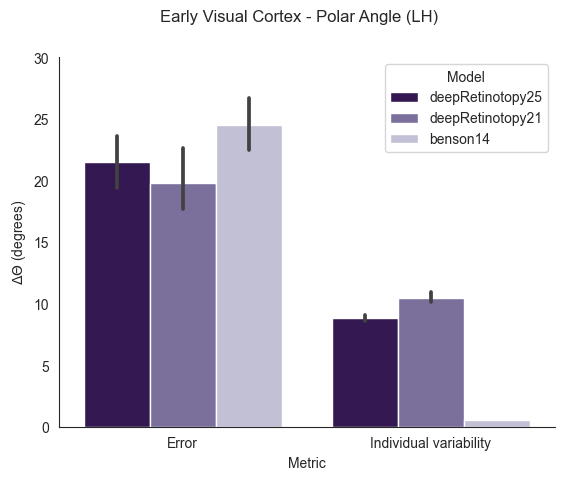

Region of interest: V1


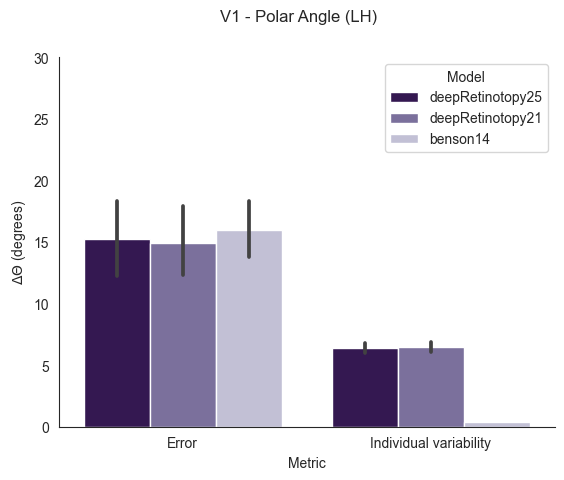

Region of interest: V2


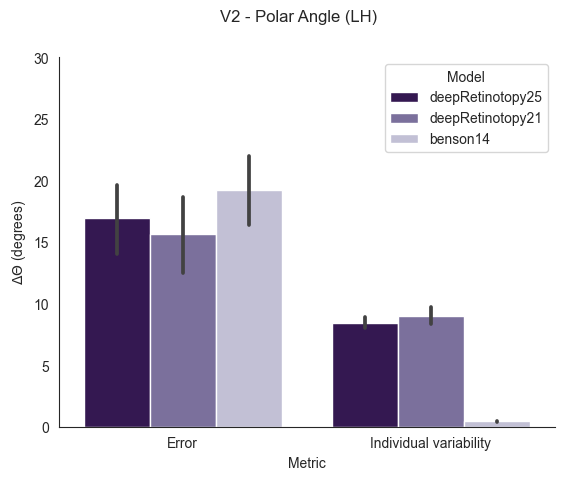

Region of interest: V3


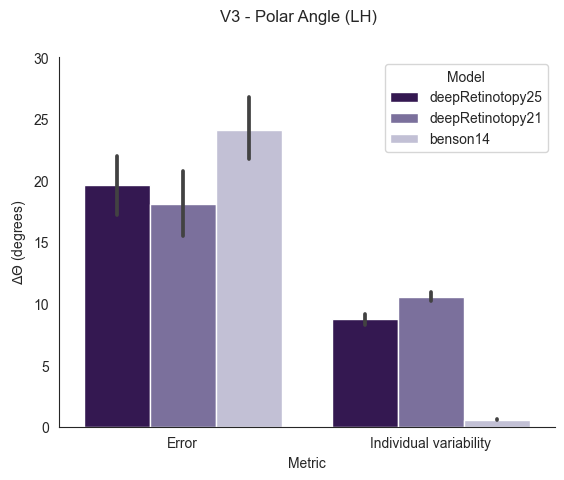

Region of interest: earlyVisualCortex


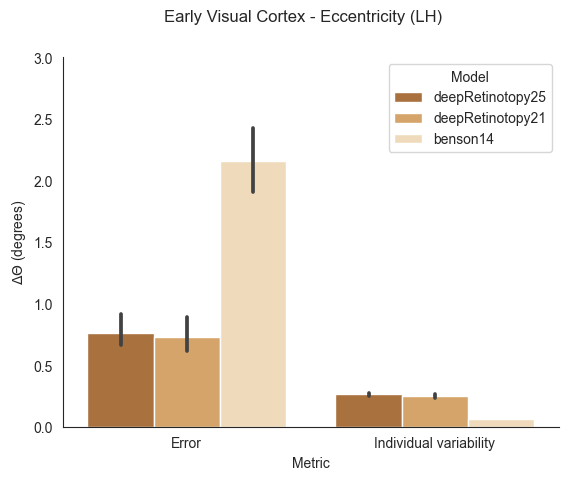

Region of interest: V1


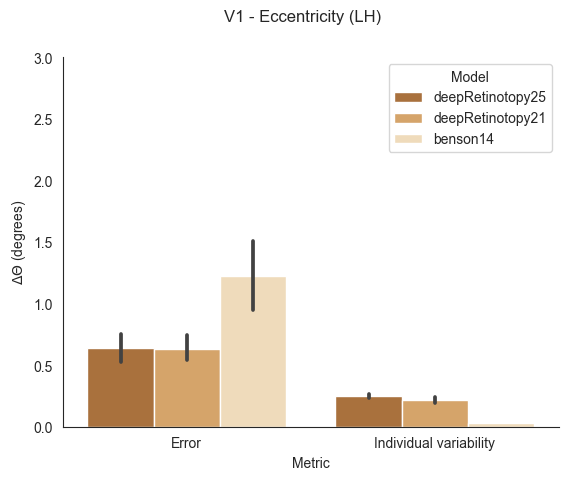

Region of interest: V2


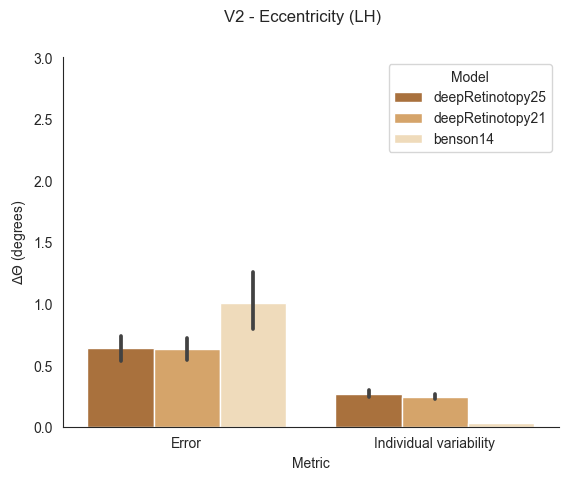

Region of interest: V3


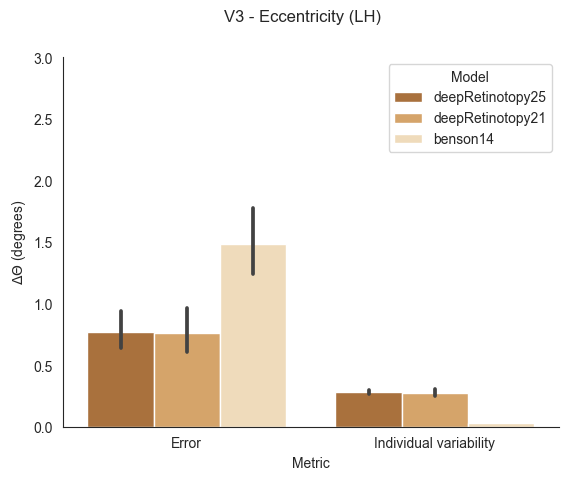

In [14]:
for retinotopic_map in ['polarAngle', 'eccentricity']:
    for region_of_interest in ['earlyVisualCortex', 'V1', 'V2', 'V3']:
        benchmark_models('/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/', 
                        retinotopic_map, 'lh', 
                        retinotopic_mapping = 'continuous', 
                        threshold = 10, 
                        list_of_models = ['deepRetinotopy25', 'deepRetinotopy21','benson14'],
                        region_of_interest=region_of_interest)

## Predicted vs Empirical pRF estimates

Here we have hexbin plots to show more fine-grained results.

Region of interest: earlyvisualcortex
Threshold: 10
0.9106429219245911
Saving plot to ../output/model_evaluation/hcp/PredictedVsEmpirical_polarAngle_both_10_earlyvisualcortex_hexbin.png and ../output/model_evaluation/hcp/PredictedVsEmpirical_polarAngle_both_10_earlyvisualcortex_hexbin.pdf


<Figure size 1000x1000 with 0 Axes>

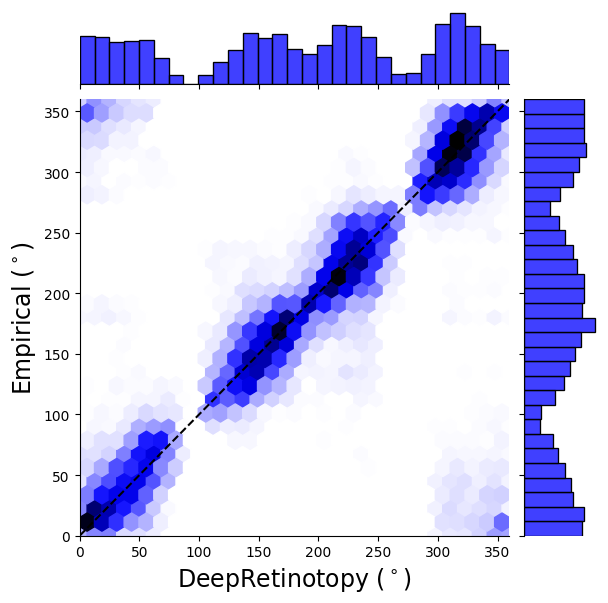

Threshold: 10
PearsonRResult(statistic=0.882068890654139, pvalue=0.0)
Saving plot to ../output/model_evaluation/hcp/PredictedVsEmpirical_eccentricity_both_10_earlyvisualcortex_hexbin.png and ../output/model_evaluation/hcp/PredictedVsEmpirical_eccentricity_both_10_earlyvisualcortex_hexbin.pdf


<Figure size 1000x1000 with 0 Axes>

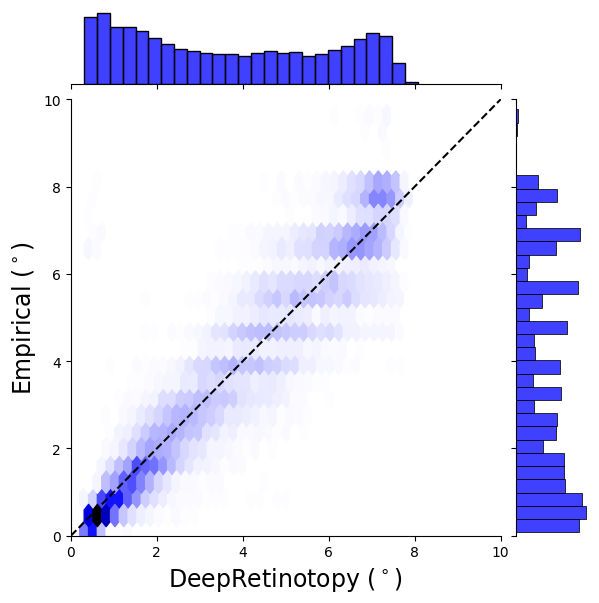

Threshold: 10
PearsonRResult(statistic=0.6679753202363423, pvalue=0.0)
Saving plot to ../output/model_evaluation/hcp/PredictedVsEmpirical_pRFsize_both_10_earlyvisualcortex_hexbin.png and ../output/model_evaluation/hcp/PredictedVsEmpirical_pRFsize_both_10_earlyvisualcortex_hexbin.pdf


<Figure size 1000x1000 with 0 Axes>

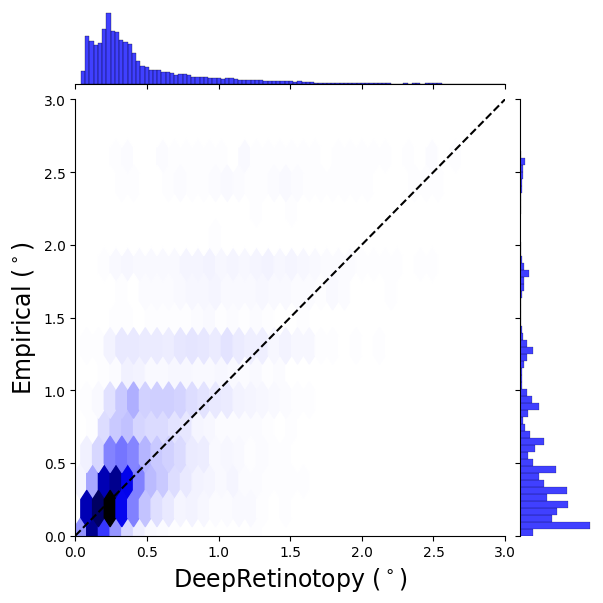

In [2]:
from functions.evaluation import predicted_vs_empirical

dataset_name = 'hcp'
path = '../HCP/freesurfer/'
retinotopic_maps = ['polarAngle', 'eccentricity', 'pRFsize']

for hemispheres in ['both']:
    for threshold in [10]:
        predicted_vs_empirical(path, dataset_name, retinotopic_maps, hemispheres = hemispheres, 
                               threshold=threshold, region_of_interest = 'earlyvisualcortex')

## Check results from model trained on bar-only data

In [ ]:

def predicted_vs_empirical_test(path, dataset_name, retinotopic_maps, hemispheres, threshold = None, region_of_interest = 'all', stimulus = 'bars1bars2', empirical_data = 'bars'):
    """Calculate the error between predicted and empirical maps for different models.
    
    Args:
        path (str): Path to the Freesurfer directory (both empirical and predicted maps should be 
            located at the deepRetinotopy folder within the individual's directory)
        list_of_sub_ids (list): List of subject IDs
        retinotopic_maps (list): List of retinotopic maps ('polarAngle', 'eccentricity' or 'pRFsize')
        hemispheres (str): Hemisphere ('lh', 'rh' or 'both')
        threshold (float): Threshold for the explained variance
        roi (str): Region of interest ('all', 'earlyvisualcortex', 'V1', 'V2' or 'V3')

    Returns:
        plt (matplotlib.pyplot): Scatter plot of the predicted vs empirical maps. 
            PNG file saved at the output folder.
    """

    # Number of nodes
    number_cortical_nodes = int(64984)
    number_hemi_nodes = int(number_cortical_nodes / 2)

    # Use data from both hemispheres or not
    if hemispheres == 'both':
        hemispheres = ['lh', 'rh']
    elif hemispheres == 'lh' or hemispheres == 'rh':
        hemispheres = [hemispheres]

    ## Region of interest
    # Region of interest used for training
    final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
    # Early visual cortex
    final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])
    print('Region of interest: ' + region_of_interest)

    if region_of_interest != 'all' and region_of_interest != 'earlyvisualcortex':
        if region_of_interest == 'V1':
            areas = ['V1v', 'V1d']
        elif region_of_interest == 'V2':
            areas = ['V2v', 'V2d']
        elif region_of_interest == 'V3':
            areas = ['V3v', 'V3d']
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_parcel(areas)

    # Make output directory
    if os.path.isdir('../output/model_evaluation/nyu/') == False:
        os.makedirs('../output/model_evaluation/nyu/')

    # List of subjects
    list_of_sub_ids = return_list_of_subs(dataset_name)
    for retinotopic_map in retinotopic_maps:
        predicted_map = []
        empirical_map = []
        for hemisphere in hemispheres:
            ROI_masked = np.zeros((32492, 1))
            visualarea = np.zeros((32492, 1))
            predicted_map_hemi = []
            empirical_map_hemi = []
            if hemisphere == 'lh':
                ROI_masked[final_mask_L_ROI == 1] = 1
                visualarea[final_mask_L == 1] = 1
            else: 
                ROI_masked[final_mask_R_ROI == 1] = 1
                visualarea[final_mask_R == 1] = 1

            # Final mask 
            mask = ROI_masked + visualarea
            mask = mask == 2

            if region_of_interest == 'all':
                mask_final = ROI_masked
            else:
                mask_final = mask

            for i in range(len(list_of_sub_ids)):
                # Load predicted maps
                if stimulus == 'bars1bars2':
                    cmap_plot = 'Oranges'
                    tmp_predicted_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/tmp/data_from_david/predicted_data_bars', list_of_sub_ids[i] + '.fs_predicted_' + 
                                                        retinotopic_map + '_' + hemisphere + '_curvatureFeat_model_bars.func.gii')).agg_data()).reshape(
                                                        number_hemi_nodes, -1)[mask_final == 1]
                    # tmp_predicted_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/tmp/empirical_data_bars', list_of_sub_ids[i] + '.fs_empirical_' + 
                    #                                     retinotopic_map + '_' + hemisphere + '_masked_bars1bars2.func.gii')).agg_data()).reshape(
                    #                                 number_hemi_nodes, -1)[mask_final == 1]
                    if retinotopic_map == 'polarAngle' and hemisphere == 'rh': # one maps with odd values
                        tmp_predicted_map[tmp_predicted_map > 360]= 360
                        tmp_predicted_map[tmp_predicted_map < 0]= 0

                elif stimulus == 'wedge-ring':
                    cmap_plot = 'Reds'
                    tmp_predicted_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/tmp/empirical_data_wedge-ring', list_of_sub_ids[i] + '.fs_empirical_' + 
                                                        retinotopic_map + '_' + hemisphere + '_masked_retccwretexpretcwretcon.func.gii')).agg_data()).reshape(
                                                        number_hemi_nodes, -1)[mask_final == 1]
                # Load empirical maps

                # Empirical bar maps
                tmp_empirical_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/tmp/data_from_david/empirical_data_bars', list_of_sub_ids[i] + '.fs_empirical_' + 
                                                        retinotopic_map + '_' + hemisphere + '_masked_bars1bars2.func.gii')).agg_data()).reshape(
                                                    number_hemi_nodes, -1)[mask_final == 1]

                # # Empirical original maps
                # tmp_empirical_map = np.array(nib.load(osp.join('/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/', list_of_sub_ids[i] + '/deepRetinotopy/' + list_of_sub_ids[i] + '.fs_empirical_' + 
                #                                         retinotopic_map + '_' + hemisphere + '_masked.func.gii')).agg_data()).reshape(
                #                                     number_hemi_nodes, -1)[mask_final == 1]
                                
                if threshold != None:
                    data_directory = '/deepRetinotopy/'
                    explained_variance = np.array(nib.load(osp.join(path, list_of_sub_ids[i] + data_directory + list_of_sub_ids[i] + '.fs_empirical_variance_explained_' +
                                                        hemisphere + '.func.gii')).agg_data()).reshape(
                                                        number_hemi_nodes, -1)[mask_final == 1]
                    tmp_predicted_map = tmp_predicted_map[explained_variance > threshold]              
                    tmp_empirical_map = tmp_empirical_map[explained_variance > threshold]

                # Transform polar angle values from lh to range from 0 to 90 and 270 to 360 degrees
                if retinotopic_map == 'polarAngle' and hemisphere == 'lh':
                    tmp_predicted_map = transform_polarangle(tmp_predicted_map) 
                    # tmp_empirical_map = transform_polarangle(tmp_empirical_map)

                predicted_map_hemi = predicted_map_hemi + list(np.array(tmp_predicted_map).flatten())
                empirical_map_hemi = empirical_map_hemi + list(np.array(tmp_empirical_map).flatten())

            predicted_map = predicted_map + list(np.array(predicted_map_hemi).flatten())
            empirical_map = empirical_map + list(np.array(empirical_map_hemi).flatten())
            
        if threshold != None:
            print('Threshold: ' + str(threshold))
        if stimulus == 'bars1bars2':
            name_data = 'Bar-only model'
        elif stimulus == 'wedge-ring':
            name_data = 'Wedge/Ring data'
        data = {name_data: predicted_map, 'Empirical data': empirical_map}
        data = pd.DataFrame(data)
        fig = plt.figure()
        sns.kdeplot(y = data['Empirical data'], x =data[name_data],cmap=cmap_plot, fill=True,cbar=True)
        # sns.jointplot(y = data['Empirical data'], x =data[name_data],color='orangered', kind='hex')

        if retinotopic_map ==  'polarAngle':
            plt.plot([0, 360], [0, 360], 'k--')
            plt.ylim(0,360)
            plt.xlim(0,360)
            if len(hemispheres) > 1:
                fig.suptitle('Polar Angle')
            else:
                fig.suptitle('Polar Angle - ' + hemispheres[0])
        elif retinotopic_map == 'eccentricity':
            plt.plot([0, 10], [0, 10], 'k--')
            plt.ylim(0,10)
            plt.xlim(0,10)
            if len(hemispheres) > 1:
                fig.suptitle('Eccentricity')
            else:
                fig.suptitle('Eccentricity - ' + hemispheres[0])

        elif retinotopic_map == 'pRFsize':
            plt.plot([0, 8], [0, 8], 'k--')
            plt.ylim(0,8)
            plt.xlim(0,8)
            if len(hemispheres) > 1:
                fig.suptitle('pRF size')
            else:
                fig.suptitle('pRF size - ' + hemispheres[0])
        if stimulus == 'bars1bars2':
            if threshold != None:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedBarVsEmpiricalBar_' + retinotopic_map + '_both_' + str(threshold) + '_' + region_of_interest + '.png')
            else:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedBarVsEmpiricalBar_' + retinotopic_map + '_both_' + region_of_interest + '.png')
        elif stimulus == 'wedge-ring':
            if threshold != None:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedWedgeringVsEmpirical_' + retinotopic_map + '_both_' + str(threshold) + '_' + region_of_interest + '.png')
            else:
                plt.savefig('../output/model_evaluation/' + dataset_name + '/PredictedWedgeringVsEmpirical_' + retinotopic_map + '_both_' + region_of_interest + '.png')
        plt.show()
    return

Region of interest: earlyvisualcortex


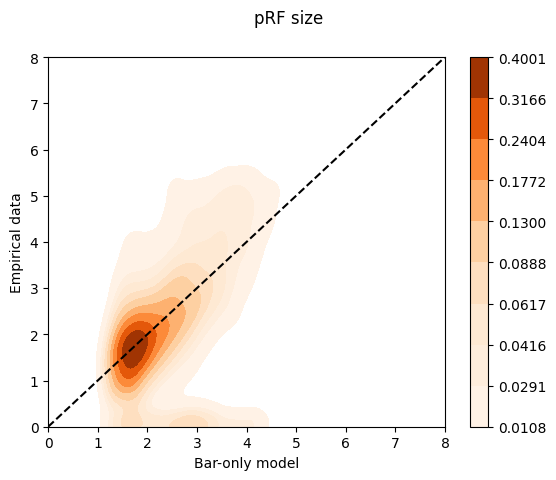

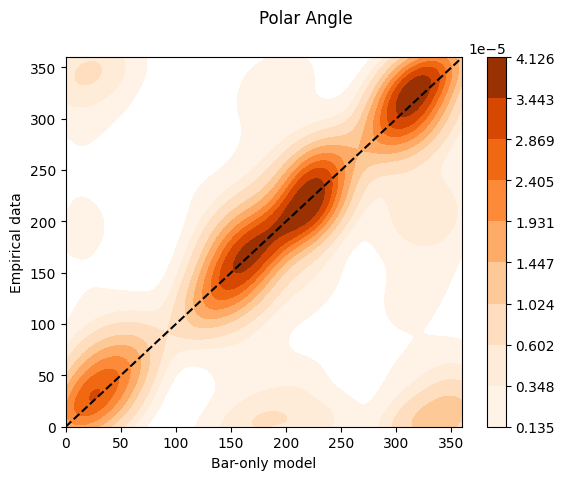

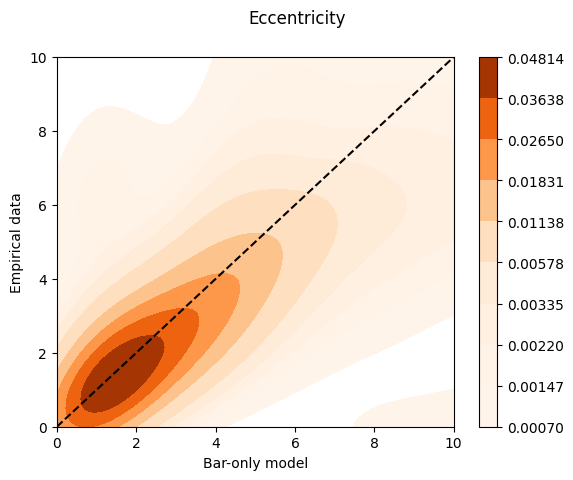

In [ ]:


dataset_name = 'hcp'
path = '../HCP/freesurfer/'
retinotopic_maps = ['pRFsize', 'polarAngle', 'eccentricity']
for hemispheres in ['both']:
    for threshold in [None]:
        predicted_vs_empirical_test(path, dataset_name, retinotopic_maps, hemispheres = hemispheres, threshold=threshold, region_of_interest = 'earlyvisualcortex')

### For segmentation later on

In [ ]:
cd ../HCP/freesurfer
for sub in *; do
    cd $sub/surf
    # Estimate retinotopic maps with benson14 model
    mkdir -p ../bayesian_retinotopy/
    #TODO: transform empirical data to from fs to native space
    python -m neuropythy register_retinotopy $sub \
       --verbose                                      \
       --surf-outdir=./bayesian_retinotopy/ --surf-format="mgz"            \
       --no-volume-export                             \
       --lh-angle=lh.all-angle.mgz                    \
       --lh-eccen=lh.all-eccen.mgz                    \
       --lh-weight=lh.all-vexpl.mgz                   \
       --lh-radius=lh.all-sigma.mgz                   \
       --rh-angle=rh.all-angle.mgz                    \
       --rh-eccen=rh.all-eccen.mgz                    \
       --rh-weight=rh.all-vexpl.mgz                   \
       --rh-radius=rh.all-sigma.mgz
    
    # Convert retinotopic maps to gifti

    for hemisphere in lh rh; do
        for metric in angle eccen sigma varea; do
            mris_convert -c ../bayesian_retinotopy/"$hemisphere".benson14_"$metric".mgz "$hemisphere".white \
                        ../bayesian_retinotopy/"$hemisphere".benson14_"$metric".gii
        done
    done
    # Convert polar angle maps
    for hemisphere in lh rh; do
        # Convert to 0-360 range
        python -c "import sys; sys.path.append('/home/ribeiro/Projects/deepRetinotopy_validation/'); from functions.preprocess import transform_polarangle_neuropythy; transform_polarangle_neuropythy('../bayesian_retinotopy/"$hemisphere".benson14_angle.gii', '"$hemisphere"')"
    done                  
    cd ../..
done